# Treemapping procedure

In this notebook, gene-expression vectors are transformed into images. Firstly, the KEGG BRITE functional-hierarchies tree is converted into a *KEGG BRITE functional-hierarchies image* **T**, whose resolution has already been determined in `KEGG_BRITE_Image_Resolution` notebook. The locations of every gene-expression value in **T** are determined by the KEGG BRITE functional hierarchies to which the corresponding gene is associated as well as by the mean expression value of the gene across all PanCancer samples. In order to generate **T**, we used the [R package treemap](https://cran.r-project.org/web/packages/treemap/treemap.pdf), which implements the ordered-treemap, pivot-by-size,
algorithm presented in [*Bederson et al.*](http://www.cs.umd.edu/hcil/trs/2001-18/2001-18.pdf)

Then, for every gene-expression vector **g<sub>i</sub>**, we generate the corresponding gene-expression image **G<sub>i</sub>**, using **T** as a template to complete the mapping process.

Firstly, we load the KEGG Brite hierarchical dataset generated in `1-KEGG_BRITE_Hierarchy` Python notebook:

In [1]:
start.time <- Sys.time()
exp_to_tree_map <- read.csv("./KEGG_exp_to_tree_map.csv", header = TRUE, stringsAsFactors = FALSE)
end.time <- Sys.time()

In [2]:
end.time - start.time

Time difference of 1.185902 mins

In [3]:
# Number of ENSEMBLE genes included in the dataset
length(unique(exp_to_tree_map$geneId))

[1] 7509

In [4]:
head(exp_to_tree_map)

ERROR while rich displaying an object: Error in sprintf(wrap, caption, header, body): 'fmt' length exceeds maximal format length 8192

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]]

geneId,geneName,keggId,keggBriteId,Functional.Annotation.Group,Functional.Annotation.Subgroup,Functional.Annotation,TCGA.02.0047.01,TCGA.02.0055.01,TCGA.02.2483.01,⋯,TCGA.ZS.A9CE.01,TCGA.ZS.A9CF.01,TCGA.ZS.A9CF.02,TCGA.ZS.A9CG.01,TCGA.ZT.A8OM.01,TCGA.ZU.A8S4.01,TCGA.ZU.A8S4.11,TCGA.ZX.AA5X.01,tamPixel,order
<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000187961.13,KLHL17,hsa:339451,1,Genes and Proteins,Orthologs and modules,KEGG Orthology (KO),1.3225,2.3135,2.5707,⋯,0.8883,1.7532,0.7664,0.2998,1.9226,2.7336,-0.3752,2.7972,1,1.992469
ENSG00000187961.13,KLHL17,hsa:339451,4121,Genes and Proteins,Protein families: genetic information processing,Ubiquitin system,1.3225,2.3135,2.5707,⋯,0.8883,1.7532,0.7664,0.2998,1.9226,2.7336,-0.3752,2.7972,1,1.992469
ENSG00000188290.10,HES4,hsa:57801,1,Genes and Proteins,Orthologs and modules,KEGG Orthology (KO),4.1604,3.6148,3.8729,⋯,-0.3201,0.9642,-0.8084,0.2762,5.8595,3.9156,-0.1504,4.3751,1,2.791702
ENSG00000188290.10,HES4,hsa:57801,3000,Genes and Proteins,Protein families: genetic information processing,Transcription factors,4.1604,3.6148,3.8729,⋯,-0.3201,0.9642,-0.8084,0.2762,5.8595,3.9156,-0.1504,4.3751,1,2.791702
ENSG00000187608.8,ISG15,hsa:9636,1,Genes and Proteins,Orthologs and modules,KEGG Orthology (KO),5.8166,6.9599,5.9072,⋯,6.4074,6.1183,5.0592,5.2122,7.4520,6.6671,4.7783,9.7576,1,6.491173
ENSG00000187608.8,ISG15,hsa:9636,4121,Genes and Proteins,Protein families: genetic information processing,Ubiquitin system,5.8166,6.9599,5.9072,⋯,6.4074,6.1183,5.0592,5.2122,7.4520,6.6671,4.7783,9.7576,1,6.491173


To be coherent with the information given in the paper, we must indicate that in the KEGG BRITE hierarchical dataset shown above, "Functional.Annotation.Group" column contains the root name of the KEGG BRITE functional-hierarchies tree; "Functional.Annotation.Subgroup" column includes the *functional categories*, corresponding to the first level of the tree; and "Functional.Annotation" column contains the *functional hierarchies*, the second level of the tree.

## KEGG BRITE functional-hierarchies image

### Realtions multiplicity exploration

ENSEMBLE-Hugo N:1 relation:

In [5]:
ens_hugo <- exp_to_tree_map[, c("geneId", "geneName")]
nrow(ens_hugo)

[1] 18494

In [6]:
ens_hugo <- ens_hugo[!duplicated(ens_hugo), ]
nrow(ens_hugo)

[1] 7509

In [7]:
max(table(ens_hugo["geneId"]))

[1] 1

In [8]:
max(table(ens_hugo["geneName"]))

[1] 2

Hugo-KEGG ID N:M relation:

In [9]:
hugo_kegg <- exp_to_tree_map[, c("geneName", "keggId")]
nrow(hugo_kegg)

[1] 18494

In [10]:
hugo_kegg <- hugo_kegg[!duplicated(hugo_kegg), ]
nrow(hugo_kegg)

[1] 7925

In [11]:
max(table(hugo_kegg["geneName"]))

[1] 6

In [12]:
max(table(hugo_kegg["keggId"]))

[1] 5

KEGG ID-KEGG Brite N:M relation:

In [13]:
kegg_brite <- exp_to_tree_map[, c("keggId", "keggBriteId")]
nrow(kegg_brite)

[1] 18494

In [14]:
kegg_brite <- kegg_brite[!duplicated(kegg_brite), ]
nrow(kegg_brite)

[1] 17673

In [15]:
max(table(kegg_brite["keggId"]))

[1] 9

In [16]:
max(table(kegg_brite["keggBriteId"]))

[1] 7588

KEGG Brite-Functional annotation 1:1 relation:

In [17]:
brite_annot <- exp_to_tree_map[, c("keggBriteId", "Functional.Annotation")]
nrow(brite_annot)

[1] 18494

In [18]:
brite_annot <- brite_annot[!duplicated(brite_annot), ]
nrow(brite_annot)

[1] 46

In [19]:
max(table(brite_annot["keggBriteId"]))

[1] 1

In [20]:
max(table(brite_annot["Functional.Annotation"]))

[1] 1

Functional annotation-Functional subgroup N:1 relation:

In [21]:
annot_group <- exp_to_tree_map[, c("Functional.Annotation", "Functional.Annotation.Subgroup")]
nrow(annot_group)

[1] 18494

In [22]:
annot_group <- annot_group[!duplicated(annot_group), ]
nrow(annot_group)

[1] 46

In [23]:
max(table(annot_group["Functional.Annotation"]))

[1] 1

In [24]:
max(table(annot_group["Functional.Annotation.Subgroup"]))

[1] 19

When performing the treemapping procedure, `geneId` column must be the last hierarchy level (leaves of the tree), as the `exp_to_tree_map` table contains the gene expression values of the ENSEMBLE ID genes.

It is assumed that 1 ENSEMBLE ID can be associated to > 1 KEGG BRITE functional hierarchy at the same time, but 1 ENSEMBLE ID can also be duplicated in the same KEGG BRITE functional hierarchy (because of the ENSEMBLE-Hugo 1:N relation, Hugo-KEGG ID N:M relation and KEGG gene ID-KEGG Brite N:M relation).

In [25]:
ens_map <- exp_to_tree_map[, c("Functional.Annotation.Subgroup", "Functional.Annotation", "geneId")]

# Repetitions of 1 ENSEMBL ID in the same functional annotation
sum(duplicated(ens_map))

[1] 762

In [26]:
ens_map <- ens_map[!duplicated(ens_map), ]

In [27]:
# Times ENSEMBLE IDs are associated to > 1 functional annotation
sum(duplicated(ens_map["geneId"]))

[1] 10223

Repetitions of 1 ENSEMBLE ID in the same functional hyerarchies are removed. We assume that a gene can be either associated or not associated to one functional hierarchy. Alternatively, other approaches could consider the repetitions of genes in one functional hierarchy in the treemap, or setting a gene expression value in the treemap equals to the product of the number of repetitions and the expression value of the gene.

In [28]:
# Remove repetitions of 1 ENSEMBLE ID in the same functional annotations
exp_to_tree_map <- exp_to_tree_map[!duplicated(exp_to_tree_map[, 
                        c("Functional.Annotation.Subgroup", "Functional.Annotation", "geneId")]), ]
nrow(exp_to_tree_map)

[1] 17732

In [29]:
head(exp_to_tree_map)

ERROR while rich displaying an object: Error in sprintf(wrap, caption, header, body): 'fmt' length exceeds maximal format length 8192

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]]

geneId,geneName,keggId,keggBriteId,Functional.Annotation.Group,Functional.Annotation.Subgroup,Functional.Annotation,TCGA.02.0047.01,TCGA.02.0055.01,TCGA.02.2483.01,⋯,TCGA.ZS.A9CE.01,TCGA.ZS.A9CF.01,TCGA.ZS.A9CF.02,TCGA.ZS.A9CG.01,TCGA.ZT.A8OM.01,TCGA.ZU.A8S4.01,TCGA.ZU.A8S4.11,TCGA.ZX.AA5X.01,tamPixel,order
<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000187961.13,KLHL17,hsa:339451,1,Genes and Proteins,Orthologs and modules,KEGG Orthology (KO),1.3225,2.3135,2.5707,⋯,0.8883,1.7532,0.7664,0.2998,1.9226,2.7336,-0.3752,2.7972,1,1.992469
ENSG00000187961.13,KLHL17,hsa:339451,4121,Genes and Proteins,Protein families: genetic information processing,Ubiquitin system,1.3225,2.3135,2.5707,⋯,0.8883,1.7532,0.7664,0.2998,1.9226,2.7336,-0.3752,2.7972,1,1.992469
ENSG00000188290.10,HES4,hsa:57801,1,Genes and Proteins,Orthologs and modules,KEGG Orthology (KO),4.1604,3.6148,3.8729,⋯,-0.3201,0.9642,-0.8084,0.2762,5.8595,3.9156,-0.1504,4.3751,1,2.791702
ENSG00000188290.10,HES4,hsa:57801,3000,Genes and Proteins,Protein families: genetic information processing,Transcription factors,4.1604,3.6148,3.8729,⋯,-0.3201,0.9642,-0.8084,0.2762,5.8595,3.9156,-0.1504,4.3751,1,2.791702
ENSG00000187608.8,ISG15,hsa:9636,1,Genes and Proteins,Orthologs and modules,KEGG Orthology (KO),5.8166,6.9599,5.9072,⋯,6.4074,6.1183,5.0592,5.2122,7.4520,6.6671,4.7783,9.7576,1,6.491173
ENSG00000187608.8,ISG15,hsa:9636,4121,Genes and Proteins,Protein families: genetic information processing,Ubiquitin system,5.8166,6.9599,5.9072,⋯,6.4074,6.1183,5.0592,5.2122,7.4520,6.6671,4.7783,9.7576,1,6.491173


### Genes to colours

We create a treemap in which every color maps to a distinct gene. Hence, all leaves in the KEGG BRITE functional hierarchies tree corresponding to the same gene are represented by the same color.

In [30]:
gene <- unique(exp_to_tree_map$geneId)
length(gene)

[1] 7509

We first generate a set of 65536 RGB colors:

In [31]:
start.time <- Sys.time()
col_rgb <- character()
for (i in 0:255) {
  for (j in 0:255) {
    col_rgb <- append(col_rgb, rgb(red=i, green=j, blue=j, maxColorValue=255))
  }
}
end.time <- Sys.time()

In [32]:
end.time - start.time

Time difference of 11.95584 secs

In [33]:
length(col_rgb)

[1] 65536

From the complete set of colours, we select a subset of 7509 colors, in order to associate one distinct color to every gene:

In [34]:
gene_color <- data.frame(color = col_rgb[seq(from=1, to=length(col_rgb), 
                by=as.integer(length(col_rgb)/length(gene)))][1:length(gene)], stringsAsFactors = FALSE)

In [35]:
rownames(gene_color) <- gene

In [36]:
# Background color, e.g. #FFFFFF, used later to generate the PNG image, 
# can not be contained in the set of colors
tail(gene_color)

,color
,<chr>
ENSG00000012817.15,#EA7878
ENSG00000198692.9,#EA8080
ENSG00000105227.14,#EA8888
ENSG00000164237.8,#EA9090
ENSG00000175048.16,#EA9898
ENSG00000188706.12,#EAA0A0


We create a new column in the `exp_to_tree_map` dataset that specifies the colors to which genes are associated:

In [37]:
exp_to_tree_map["colorGene"] <- gene_color[exp_to_tree_map$geneId, "color"]

In [38]:
head(exp_to_tree_map)

ERROR while rich displaying an object: Error in sprintf(wrap, caption, header, body): 'fmt' length exceeds maximal format length 8192

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]]

geneId,geneName,keggId,keggBriteId,Functional.Annotation.Group,Functional.Annotation.Subgroup,Functional.Annotation,TCGA.02.0047.01,TCGA.02.0055.01,TCGA.02.2483.01,⋯,TCGA.ZS.A9CF.01,TCGA.ZS.A9CF.02,TCGA.ZS.A9CG.01,TCGA.ZT.A8OM.01,TCGA.ZU.A8S4.01,TCGA.ZU.A8S4.11,TCGA.ZX.AA5X.01,tamPixel,order,colorGene
<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSG00000187961.13,KLHL17,hsa:339451,1,Genes and Proteins,Orthologs and modules,KEGG Orthology (KO),1.3225,2.3135,2.5707,⋯,1.7532,0.7664,0.2998,1.9226,2.7336,-0.3752,2.7972,1,1.992469,#000000
ENSG00000187961.13,KLHL17,hsa:339451,4121,Genes and Proteins,Protein families: genetic information processing,Ubiquitin system,1.3225,2.3135,2.5707,⋯,1.7532,0.7664,0.2998,1.9226,2.7336,-0.3752,2.7972,1,1.992469,#000000
ENSG00000188290.10,HES4,hsa:57801,1,Genes and Proteins,Orthologs and modules,KEGG Orthology (KO),4.1604,3.6148,3.8729,⋯,0.9642,-0.8084,0.2762,5.8595,3.9156,-0.1504,4.3751,1,2.791702,#000808
ENSG00000188290.10,HES4,hsa:57801,3000,Genes and Proteins,Protein families: genetic information processing,Transcription factors,4.1604,3.6148,3.8729,⋯,0.9642,-0.8084,0.2762,5.8595,3.9156,-0.1504,4.3751,1,2.791702,#000808
ENSG00000187608.8,ISG15,hsa:9636,1,Genes and Proteins,Orthologs and modules,KEGG Orthology (KO),5.8166,6.9599,5.9072,⋯,6.1183,5.0592,5.2122,7.4520,6.6671,4.7783,9.7576,1,6.491173,#001010
ENSG00000187608.8,ISG15,hsa:9636,4121,Genes and Proteins,Protein families: genetic information processing,Ubiquitin system,5.8166,6.9599,5.9072,⋯,6.1183,5.0592,5.2122,7.4520,6.6671,4.7783,9.7576,1,6.491173,#001010


Now, we generate the KEGG BRITE functional-hierarchies treemap, and show it as an image with an arbitrary resolution:

In [39]:
library(treemap)

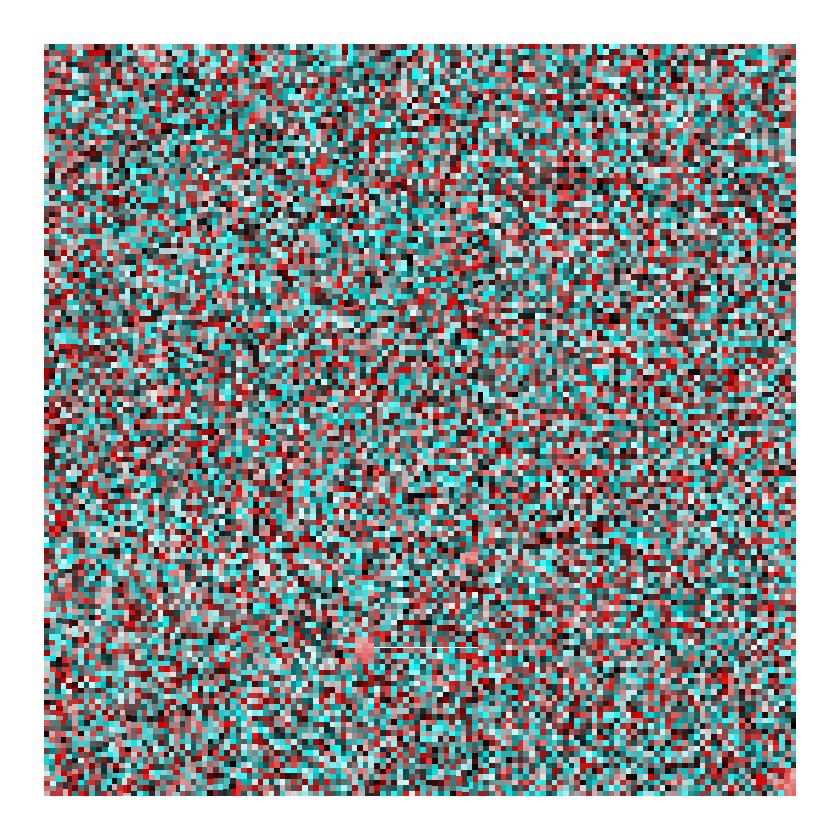

In [40]:
start.time <- Sys.time()
res <- treemap(dtf=exp_to_tree_map, index=c("Functional.Annotation.Subgroup", "Functional.Annotation", "geneId"), 
               vSize="tamPixel", vColor="colorGene", type="color", algorithm="pivotSize", sortID="order", 
               fontsize.labels=0, fontsize.title=0,
               border.lwds=0, position.legend="none", aspRatio=1, frame.plot=FALSE, draw=TRUE)
end.time <- Sys.time()

In [41]:
end.time - start.time

Time difference of 1,304629 mins

The output dataset corresponds to a continuous description of the generated treemap:

In [42]:
df_res <- res$tm
head(df_res)

Functional.Annotation.Subgroup,Functional.Annotation,geneId,vSize,vColor,stdErr,vColorValue,level,x0,y0,w,h,color
<fct>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<lgl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Orthologs and modules,KEGG Orthology (KO),ENSG00000000003.14,1,#E78080,1,NA,3,"0,8941280","0,19418004","0,007562284","0,007457432",#E78080
Orthologs and modules,KEGG Orthology (KO),ENSG00000000938.12,1,#044848,1,NA,3,"0,8034905","0,40306476","0,007558056","0,007461603",#044848
Orthologs and modules,KEGG Orthology (KO),ENSG00000000971.15,1,#149898,1,NA,3,"0,8336708","0,23892978","0,007560419","0,007459271",#149898
Orthologs and modules,KEGG Orthology (KO),ENSG00000001084.10,1,#C2D0D0,1,NA,3,"0,7580666","0,01493311","0,007553043","0,007466556",#C2D0D0
Orthologs and modules,KEGG Orthology (KO),ENSG00000001461.16,1,#038080,1,NA,3,"0,7505411","0,28368828","0,007559362","0,007460315",#038080
Orthologs and modules,KEGG Orthology (KO),ENSG00000001561.6,1,#C20808,1,NA,3,"0,6372110","0,39560320","0,007558105","0,007461555",#C20808


From the output dataset, we only select the rows corresponding to genes ('pixels' of the generated treemap), the leaves of KEGG BRITE functional hierarchy tree:

In [43]:
df_res_pix <- df_res[!is.na(df_res["geneId"]), ]
nrow(df_res_pix)

[1] 17732

In [44]:
nrow(df_res_pix) == nrow(exp_to_tree_map)

[1] TRUE

We can check that all genes occupy approximately the same area in the generated treemap:

In [45]:
rect_area <- df_res_pix["w"] * df_res_pix["h"]

In [46]:
rect_area[1, ]

[1] 5,639522e-05

In [47]:
# |min - max| ~= 0
abs(min(rect_area) - max(rect_area))

[1] 1,348476e-18

Finally, in the output dataset, we sort the genes by their position in the treemap:

In [48]:
df_res_pix <- df_res_pix[order(df_res_pix["y0"], df_res_pix["x0"], decreasing=FALSE), ]
head(df_res_pix)

,Functional.Annotation.Subgroup,Functional.Annotation,geneId,vSize,vColor,stdErr,vColorValue,level,x0,y0,w,h,color
,<fct>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<lgl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
9477,Protein families: genetic information processing,Spliceosome,ENSG00000096063.14,1,#C0B0B0,1,NA,3,"0,000000000",0,"0,008236726","0,006846800",#C0B0B0
9500,Protein families: genetic information processing,Spliceosome,ENSG00000132424.14,1,#C43030,1,NA,3,"0,008236726",0,"0,008472062","0,006656611",#C43030
9529,Protein families: genetic information processing,Spliceosome,ENSG00000204389.9,1,#BF3838,1,NA,3,"0,016708788",0,"0,009077209","0,006212837",#BF3838
9484,Protein families: genetic information processing,Spliceosome,ENSG00000106211.8,1,#CCB8B8,1,NA,3,"0,025785997",0,"0,006051473","0,009319255",#CCB8B8
9472,Protein families: genetic information processing,Spliceosome,ENSG00000070756.13,1,#D80808,1,NA,3,"0,031837469",0,"0,006051473","0,009319255",#D80808
7599,Protein families: genetic information processing,Chaperones and folding catalysts,ENSG00000263464.2,1,#0D9898,1,NA,3,"0,037888942",0,"0,007687395","0,007336063",#0D9898


In [49]:
# Check we have one distinct color for every gene
length(unique(df_res_pix$color)) == nrow(gene_color)

[1] TRUE

### Treemap discretization

In this subsection, we convert the KEGG BRITE functional-hierarchies treemap into an image, which represents **T**. To do so, we discretize the continuous treemap description given as the output dataset by the `treemap` package into a raster image in PNG format, whose size has already been determined in `KEGG_BRITE_Image_Resolution` notebook.

Firstly, we generate a gene-expression data frame that will be used later to generate the different gene-expression images **G<sub>i</sub>**:

In [50]:
tcga_samples <- colnames(exp_to_tree_map)[grep("TCGA", colnames(exp_to_tree_map))]

In [51]:
gene_exp <- exp_to_tree_map[!duplicated(exp_to_tree_map[, "geneId"]), c("geneId", tcga_samples, "order")]

In [52]:
dim(gene_exp)

[1]  7509 10537

In [53]:
tail(gene_exp)

ERROR while rich displaying an object: Error in sprintf(wrap, caption, header, body): 'fmt' length exceeds maximal format length 8192

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]]

,geneId,TCGA.02.0047.01,TCGA.02.0055.01,TCGA.02.2483.01,TCGA.02.2485.01,TCGA.04.1331.01,TCGA.04.1332.01,TCGA.04.1337.01,TCGA.04.1338.01,TCGA.04.1341.01,⋯,TCGA.ZS.A9CD.01,TCGA.ZS.A9CE.01,TCGA.ZS.A9CF.01,TCGA.ZS.A9CF.02,TCGA.ZS.A9CG.01,TCGA.ZT.A8OM.01,TCGA.ZU.A8S4.01,TCGA.ZU.A8S4.11,TCGA.ZX.AA5X.01,order
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
18485,ENSG00000012817.15,"3,7614","-3,0469","2,7270","4,0019","-9,9658","-9,9658","-9,9658","-9,9658","-9,9658",⋯,"1,3051","-9,9658","3,2781","3,8491","2,2663","-5,5735","2,0289","1,8762","-9,9658","-2,9807250"
18489,ENSG00000198692.9,"4,6508","-4,0350","5,3042","4,8090","-9,9658","-9,9658","-9,9658","-9,9658","-9,9658",⋯,"4,4556","-9,9658","4,8802","5,0968","-0,0425","-9,9658","3,6405","3,9561","-9,9658","-2,4597650"
18491,ENSG00000105227.14,"1,2815","0,2881","-1,1172","0,9642","0,5955","3,4304","0,3231","-1,8836","-2,1779",⋯,"-0,4521","0,6969","-0,4325","0,7664","-0,1187","1,1316","0,5859","-1,8836","0,8246","0,6511954"
18492,ENSG00000164237.8,"4,3618","2,5924","3,5523","3,6635","4,3660","1,7995","1,7053","1,2516","0,5470",⋯,"5,2126","7,6705","6,7502","5,8888","6,5694","0,4233","4,0549","6,3338","1,0573","4,0465881"
18493,ENSG00000175048.16,"4,9426","2,9488","3,3450","3,9468","1,4547","1,9415","0,7233","0,6145","1,1447",⋯,"3,5584","2,3760","3,0740","2,4623","1,8564","1,5366","3,9232","2,8055","2,7826","2,5296664"
18494,ENSG00000188706.12,"5,7748","5,6056","4,8360","4,5571","5,1486","3,5098","5,0760","3,8187","3,0481",⋯,"5,2005","4,2366","3,6242","4,0713","5,1863","-0,3566","4,1612","3,6066","3,9829","4,5475844"


Background elements will be set to 0 values in gene-expression images, as there is no gene having 0 expression value in any sample:

In [54]:
start.time <- Sys.time()
exp_v <- unique(as.numeric(as.matrix(gene_exp[, c(tcga_samples, "order")])))
end.time <- Sys.time()

In [55]:
end.time - start.time

Time difference of 3,408635 secs

In [56]:
sum(exp_v == 0)

[1] 0

In [57]:
exp_v <- exp_v[order(exp_v)]
w <- which(exp_v > 0)
exp_v[(w[1]-3):(w[1]+2)]

[1] -0,0014238489 -0,0014045903 -0,0001337805  0,0013981905  0,0014000000
[6]  0,0014005200

In [58]:
# Add last row representing background
gene_exp <- rbind(gene_exp, c(list("#FFFFFF"), as.list(rep(0, times = (ncol(gene_exp)-1)))))

In [59]:
dim(gene_exp)

[1]  7510 10537

In [60]:
rownames(gene_exp) <- gene_exp[, "geneId"]

In [61]:
tail(gene_exp)

ERROR while rich displaying an object: Error in sprintf(wrap, caption, header, body): 'fmt' length exceeds maximal format length 8192

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]]

,geneId,TCGA.02.0047.01,TCGA.02.0055.01,TCGA.02.2483.01,TCGA.02.2485.01,TCGA.04.1331.01,TCGA.04.1332.01,TCGA.04.1337.01,TCGA.04.1338.01,TCGA.04.1341.01,⋯,TCGA.ZS.A9CD.01,TCGA.ZS.A9CE.01,TCGA.ZS.A9CF.01,TCGA.ZS.A9CF.02,TCGA.ZS.A9CG.01,TCGA.ZT.A8OM.01,TCGA.ZU.A8S4.01,TCGA.ZU.A8S4.11,TCGA.ZX.AA5X.01,order
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000198692.9,ENSG00000198692.9,"4,6508","-4,0350","5,3042","4,8090","-9,9658","-9,9658","-9,9658","-9,9658","-9,9658",⋯,"4,4556","-9,9658","4,8802","5,0968","-0,0425","-9,9658","3,6405","3,9561","-9,9658","-2,4597650"
ENSG00000105227.14,ENSG00000105227.14,"1,2815","0,2881","-1,1172","0,9642","0,5955","3,4304","0,3231","-1,8836","-2,1779",⋯,"-0,4521","0,6969","-0,4325","0,7664","-0,1187","1,1316","0,5859","-1,8836","0,8246","0,6511954"
ENSG00000164237.8,ENSG00000164237.8,"4,3618","2,5924","3,5523","3,6635","4,3660","1,7995","1,7053","1,2516","0,5470",⋯,"5,2126","7,6705","6,7502","5,8888","6,5694","0,4233","4,0549","6,3338","1,0573","4,0465881"
ENSG00000175048.16,ENSG00000175048.16,"4,9426","2,9488","3,3450","3,9468","1,4547","1,9415","0,7233","0,6145","1,1447",⋯,"3,5584","2,3760","3,0740","2,4623","1,8564","1,5366","3,9232","2,8055","2,7826","2,5296664"
ENSG00000188706.12,ENSG00000188706.12,"5,7748","5,6056","4,8360","4,5571","5,1486","3,5098","5,0760","3,8187","3,0481",⋯,"5,2005","4,2366","3,6242","4,0713","5,1863","-0,3566","4,1612","3,6066","3,9829","4,5475844"
#FFFFFF,#FFFFFF,"0,0000","0,0000","0,0000","0,0000","0,0000","0,0000","0,0000","0,0000","0,0000",⋯,"0,0000","0,0000","0,0000","0,0000","0,0000","0,0000","0,0000","0,0000","0,0000","0,0000000"


We now proceed to generate image **T** using the best pixels configuration found in `KEGG_BRITE_Image_Resolution` notebook:

In [62]:
library(grid)

In [63]:
n_width <- 175
n_height <- 175

img_path <- paste0("./GENE_COLOR_GRID_TREEMAP_", n_width, "_", n_height, ".png")

In [64]:
# Background is set to white (#FFFFFF in RRGGBB format)
png(filename = img_path, width = n_width, height = n_height, bg = "white")
# Same arguments values used in https://github.com/mtennekes/treemap/blob/master/pkg/R/createRec.R#L29
grid.rect(x = df_res_pix$x0, y = df_res_pix$y0, width = df_res_pix$w, df_res_pix$h, default.units = "npc",
          just=c("left","bottom"), gp = gpar(lwd=0, fill = df_res_pix$color))
dev.off()

png 
  2

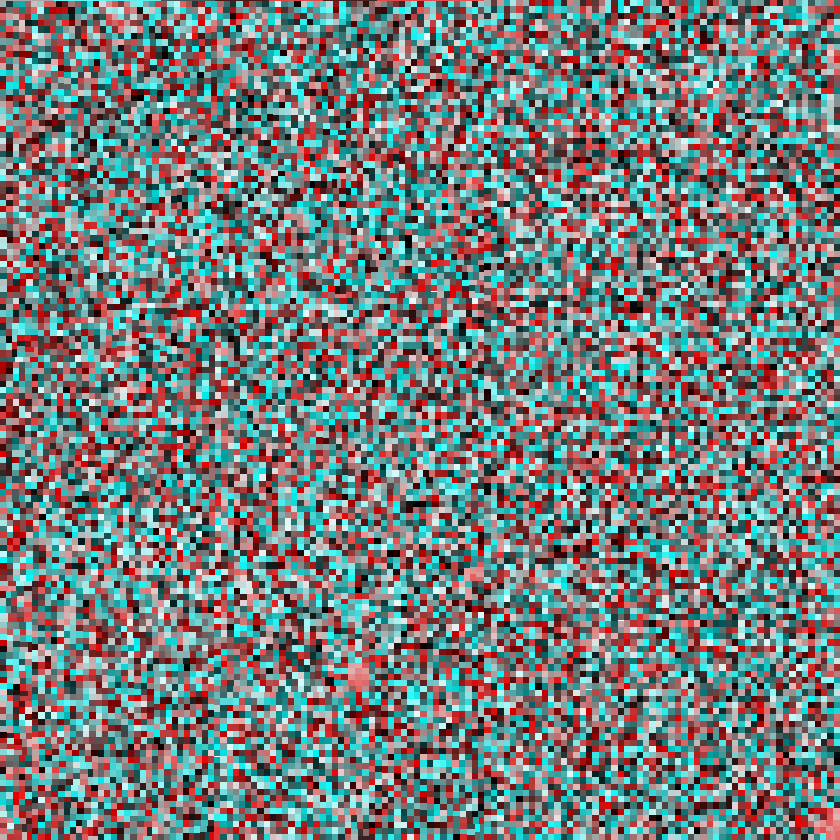

In [65]:
# Just for visualization purpose
grid.rect(x = df_res_pix$x0, y = df_res_pix$y0, width = df_res_pix$w, df_res_pix$h, default.units = "npc",
          just=c("left","bottom"), gp = gpar(lwd=0, fill = df_res_pix$color))

#### Colors to genes

Using the previously generated gene-color PNG image, we transform it to a matrix where each color is converted back to the gene it codes, in order to use **T** as a template to generate the different gene-expression images.

Firstly, we load the gene-color image:

In [66]:
library(png)

In [67]:
png_mat <- readPNG(img_path)

In [68]:
(n_row <- dim(png_mat)[1])
(n_col <- dim(png_mat)[2])

[1] 175

[1] 175

In [69]:
head(png_mat[, , 1])

"0,6352941","0,1176471","0,1176471","0,1333333","0,01568627","0,62745098","0,78039216","0,78039216","0,6313725","0,87843137",⋯,"0,58039216","0,41568627","0,5490196","0,2117647","0,2117647","0,4549020","0,4156863","0,9058824","0,9058824","0,3058824"
"0,4039216","0,4431373","0,4431373","0,6862745","0,14117647","0,66666667","0,66666667","0,87843137","0,6627451","0,01176471",⋯,"0,01568627","0,09019608","0,5215686","0,8470588","0,8470588","0,6745098","0,6274510","0,4235294","0,4235294","0,8156863"
"0,4039216","0,4431373","0,4431373","0,6862745","0,14117647","0,66666667","0,66666667","0,87843137","0,6627451","0,01176471",⋯,"0,01568627","0,09019608","0,5215686","0,8470588","0,8470588","0,6745098","0,6274510","0,4235294","0,4235294","0,8156863"
"0,8627451","0,8352941","0,8352941","0,8196078","0,79215686","0,62745098","0,62745098","0,03921569","0,4431373","0,25490196",⋯,"0,03137255","0,06274510","0,2509804","0,5450980","0,5450980","0,2745098","0,2549020","0,2392157","0,2392157","0,2862745"
"0,5960784","0,3215686","0,3215686","0,2941176","0,87058824","0,01176471","0,01176471","0,08235294","0,7058824","0,68627451",⋯,"0,56078431","0,85490196","0,8627451","0,3019608","0,3019608","0,8352941","0,4588235","0,8941176","0,8941176","0,6627451"
"0,1411765","0,9019608","0,9019608","0,7647059","0,89019608","0,01176471","0,01176471","0,08235294","0,7058824","0,68627451",⋯,"0,62745098","0,16470588","0,5803922","0,1882353","0,1882353","0,2666667","0,2627451","0,8627451","0,8627451","0,0745098"


We convert pixels values from 0-1 to 0-255 scale:

In [70]:
png_mat <- png_mat*255

We extract RGB matrices:

In [71]:
r_png_mat <- png_mat[, , 1]
g_png_mat <- png_mat[, , 2]
b_png_mat <- png_mat[, , 3]

We convert RGB color values to hexadecimal format:

In [72]:
hex_r_png_mat <- format(as.hexmode(r_png_mat), width = 2, upper.case = TRUE)
hex_g_png_mat <- format(as.hexmode(g_png_mat), width = 2, upper.case = TRUE)
hex_b_png_mat <- format(as.hexmode(b_png_mat), width = 2, upper.case = TRUE)

G and B colors component were originally generated to be the same:

In [73]:
# TRUE expected
all(hex_g_png_mat == hex_b_png_mat)

[1] TRUE

In [74]:
# FALSE expected
all(hex_r_png_mat == hex_g_png_mat)

[1] FALSE

We create RRGGBB (hexadecimal format) color value matrix:

In [75]:
hex_rgb_png_mat <- paste0("#", hex_r_png_mat, hex_g_png_mat, hex_b_png_mat)

In [76]:
head(hex_rgb_png_mat)

[1] "#A2B0B0" "#671818" "#671818" "#DC6868" "#984040" "#248080"

The discretized RRGGBB matrix contains one extra color (white background):

In [77]:
length(unique(hex_rgb_png_mat))

[1] 7510

In [78]:
(back_col <- setdiff(unique(hex_rgb_png_mat), unique(df_res_pix$color)))

[1] "#FFFFFF"

We now create a color-gene mapping table, adding background color as the last row:

In [79]:
color_gene <- data.frame(geneId = c(rownames(gene_color), back_col), stringsAsFactors = FALSE)
rownames(color_gene) <- c(gene_color$color, back_col)

In [80]:
tail(color_gene)

,geneId
,<chr>
#EA8080,ENSG00000198692.9
#EA8888,ENSG00000105227.14
#EA9090,ENSG00000164237.8
#EA9898,ENSG00000175048.16
#EAA0A0,ENSG00000188706.12
#FFFFFF,#FFFFFF


Finally, we create the template matrix, mapping the colors from the RRGGBB color value matrix to genes:

In [81]:
gene_treemap <- matrix(color_gene[hex_rgb_png_mat, "geneId"], nrow = n_row, ncol = n_col, byrow = FALSE)

The template matrix also contains one extra color corresponding to background:

In [82]:
length(unique(as.character(gene_treemap)))

[1] 7510

In [83]:
setdiff(unique(as.character(gene_treemap)), gene)

[1] "#FFFFFF"

In [84]:
back_pos <- which(gene_treemap=="#FFFFFF", arr.ind = TRUE)
back_pos[order(back_pos[, "row"], back_pos[, "col"]), ]

row,col
19,8
23,57
135,122
135,123
135,124
135,125


In [85]:
head(gene_treemap)

ENSG00000163914.4,ENSG00000122375.11,ENSG00000122375.11,ENSG00000197177.15,ENSG00000121764.11,ENSG00000231861.2,ENSG00000120436.3,ENSG00000120436.3,ENSG00000036828.13,ENSG00000171496.3,⋯,ENSG00000157542.9,ENSG00000104237.6,ENSG00000196811.11,ENSG00000173157.16,ENSG00000173157.16,ENSG00000105675.8,ENSG00000141434.11,ENSG00000102290.21,ENSG00000102290.21,ENSG00000171956.6
ENSG00000257008.6,ENSG00000188269.8,ENSG00000188269.8,ENSG00000164129.11,ENSG00000181074.3,ENSG00000056291.17,ENSG00000056291.17,ENSG00000188394.6,ENSG00000109163.6,ENSG00000188822.7,⋯,ENSG00000121764.11,ENSG00000042781.12,ENSG00000144119.3,ENSG00000164796.17,ENSG00000164796.17,ENSG00000152208.11,ENSG00000231861.2,ENSG00000081138.13,ENSG00000081138.13,ENSG00000106302.9
ENSG00000257008.6,ENSG00000188269.8,ENSG00000188269.8,ENSG00000164129.11,ENSG00000181074.3,ENSG00000056291.17,ENSG00000056291.17,ENSG00000188394.6,ENSG00000109163.6,ENSG00000188822.7,⋯,ENSG00000121764.11,ENSG00000042781.12,ENSG00000144119.3,ENSG00000164796.17,ENSG00000164796.17,ENSG00000152208.11,ENSG00000231861.2,ENSG00000081138.13,ENSG00000081138.13,ENSG00000106302.9
ENSG00000168828.5,ENSG00000082556.10,ENSG00000082556.10,ENSG00000221970.1,ENSG00000106113.18,ENSG00000179097.5,ENSG00000179097.5,ENSG00000181656.6,ENSG00000131355.14,ENSG00000102468.10,⋯,ENSG00000162594.14,ENSG00000132693.12,ENSG00000133115.11,ENSG00000163497.2,ENSG00000163497.2,ENSG00000151812.14,ENSG00000215475.4,ENSG00000111783.12,ENSG00000111783.12,ENSG00000140093.9
ENSG00000128310.2,ENSG00000162009.8,ENSG00000162009.8,ENSG00000184984.9,ENSG00000136928.4,ENSG00000179546.4,ENSG00000179546.4,ENSG00000170075.8,ENSG00000178015.4,ENSG00000171509.15,⋯,ENSG00000101251.11,ENSG00000261678.2,ENSG00000187559.5,ENSG00000137766.16,ENSG00000137766.16,ENSG00000183729.3,ENSG00000105261.7,ENSG00000169297.7,ENSG00000169297.7,ENSG00000145242.13
ENSG00000180919.3,ENSG00000186912.6,ENSG00000186912.6,ENSG00000135312.5,ENSG00000126010.5,ENSG00000179546.4,ENSG00000179546.4,ENSG00000170075.8,ENSG00000178015.4,ENSG00000171509.15,⋯,ENSG00000172139.14,ENSG00000248746.5,ENSG00000160224.16,ENSG00000165478.6,ENSG00000165478.6,ENSG00000145526.11,ENSG00000185974.6,ENSG00000184659.5,ENSG00000184659.5,ENSG00000135824.12


## Gene-expression images

Once we have generated the KEGG BRITE functional-hierarchies image **T**, we proceed to create the gene-expression images. Using **T** as a template, for each gene-expression vector **g<sub>i</sub>**, we map the expression values to the positions
of the genes in **T**, thus obtaining a unique gene-expression image **G<sub>i</sub>** for each sample *i*. 

We save each **G<sub>i</sub>** image as a *numpy* file, using the sample ID as the file name:

In [86]:
library(RcppCNPy)

In [87]:
# Create gene-expression images folder
dir_name <- paste0("gene_exp_treemap_", n_width, "_", n_height, "_npy/") 
system(paste0("mkdir -p ", dir_name), intern = TRUE)

character(0)

In [96]:
start.time <- Sys.time()
for (sample_id in tcga_samples) {
    npySave(filename = paste0(dir_name, strsplit(head(sample_id)[1], "_")[[1]][1], ".npy"), 
            object = matrix(gene_exp[gene_treemap, sample_id], nrow = n_row, ncol = n_col, byrow = FALSE))
}
end.time <- Sys.time()

In [97]:
end.time - start.time

Time difference of 16,25554 secs

Finally, we also create a treemap image with the average expression values across all samples. When visualized, the pixels colors transition is expected to be very smooth, as the average expression values across all samples have been used to sort the genes inside the treemap.

In [98]:
npySave(filename = paste0(dir_name, "AVERAGE_EXPRESSION_TCGA_SAMPLES.npy"), 
            object = matrix(gene_exp[gene_treemap, "order"], nrow = n_row, ncol = n_col, byrow = FALSE))